In [1]:
print "Stock Prediction using Lstm <Historical Stock data,Semantic score>"

Stock Prediction using Lstm <Historical Stock data,Semantic score>


In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import datetime

In [138]:
def get_stock_data(stock_name,market_name,normalized=0):
    #getting todays date
    today=datetime.datetime.now()
    #dictionary for the months for Google Finance API
    month={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    #https://finance.google.com/finance/historical?q=NASDAQ:AAPL&num=30&ei=-8_DWfi2NMOYuQSr3424BA&startdate=Sep+21%2C+2014&enddate=Sep+21%2C+2017&output=csv
    url="https://finance.google.com/finance/historical?q="+market_name+":"+stock_name+"&num=30&ei=-8_DWfi2NMOYuQSr3424BA"+"&startdate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year-2)+"&enddate="+month[today.month]+"+"+str(today.day)+"%2C+"+str(today.year)+"&output=csv"
    
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(url,header=0, names=col_names)
    
    df_stocks= pd.DataFrame(stocks)
    
    sem_cols=['Date','Semantic']
    semantic=pd.read_csv('/home/siddharth/Desktop/StockPrediction/semantic/semantic.csv',header=0,names=sem_cols)
    df_semantics=pd.DataFrame(semantic)
    df=pd.merge(semantic,stocks,how='inner',left_on=None, right_on=None)
    df=df[::-1]
    df_date=df.copy()
    df.drop(df.columns[[0,4,6]], axis=1, inplace=True)
    df_date.drop(df_date.columns[[4,6]], axis=1, inplace=True)
    columns=['Open','High','Close']
    df[columns] = df[columns].convert_objects(convert_numeric=True)
    df[columns] = df[columns].astype('float64')
    print df.dtypes
    return df,df_date

In [139]:
stock_name = '005930'
market_name= 'KRX'
df,df_date= get_stock_data(stock_name,market_name,0)
print "df---------------------------"
print df.tail()
print "df with date-----------------"
print df_date.tail()

Semantic    float64
Open        float64
High        float64
Close       float64
dtype: object
df---------------------------
   Semantic       Open       High      Close
4       0.0  1265000.0  1269000.0  1265000.0
3       0.0  1244000.0  1282000.0  1269000.0
2       0.0  1248000.0  1260000.0  1254000.0
1       0.0  1260000.0  1272000.0  1252000.0
0       0.0  1260000.0  1263000.0  1260000.0
df with date-----------------
        Date  Semantic       Open       High      Close
4  16-Oct-15       0.0  1265000.0  1269000.0  1265000.0
3  15-Oct-15       0.0  1244000.0  1282000.0  1269000.0
2  14-Oct-15       0.0  1248000.0  1260000.0  1254000.0
1  13-Oct-15       0.0  1260000.0  1272000.0  1252000.0
0  12-Oct-15       0.0  1260000.0  1263000.0  1260000.0


/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [140]:
maxhigh=max(df['High'])
maxclose=max(df['Close'])
maxopen=max(df['Open'])
df['High']=df['High']/max(df['High'])
df['Close']=df['Close']/max(df['Close'])
df['Open']=df['Open']/max(df['Open'])
print df.head()

     Semantic      Open      High     Close
354  0.021250  0.965296  0.961624  0.956360
353 -0.054500  0.985666  0.977273  0.955987
352  0.000000  0.980762  0.972429  0.963819
351 -0.113333  1.000000  0.989568  0.963446
350  0.096000  0.999623  1.000000  1.000000


In [141]:
def model_data(stock,seq_len):
    features=len(stock.columns)
    data=stock.as_matrix()
    print data

In [142]:
#main lstm !--! Yo ready for work
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [143]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [144]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (314, 5, 4))
('y_train', (314,))
('X_test', (35, 5, 4))
('y_test', (35,))


In [145]:
model = build_model2([4,window,1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/home/siddharth/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`


In [146]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)


In [147]:
diff=[]
ratio=[]
p = model.predict(X_test)
print "index","    actual        ","predicted     ","error          ","   difference       "
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    k=((y_test[u]/pr)-1)*100
    print(u, y_test[u], pr, k, abs(y_test[u]- pr))

index     actual         predicted      error              difference       
(0, 0.94852666915330097, 0.9135235, 3.8316665241811876, 0.035003173956004829)
(1, 0.93248787765759045, 0.91486472, 1.9263130798701678, 0.017623158743558465)
(2, 0.92950391644908614, 0.91544783, 1.5354326939089002, 0.014056085295216514)
(3, 0.92875792614696007, 0.91542321, 1.4566717886441705, 0.013334711711382674)
(4, 0.89071242073853041, 0.91312015, -2.4539738624406282, 0.022407729827570666)
(5, 0.89891831406191725, 0.90961862, -1.176350379463198, 0.010700302042208731)
(6, 0.85602387168966798, 0.90509862, -5.422032965390966, 0.049074745387205798)
(7, 0.83215218202163377, 0.89924556, -7.4610741625413812, 0.067093378147586202)
(8, 0.83923908989183138, 0.8915388, -5.8662291520104271, 0.052299708917220133)
(9, 0.86161879895561355, 0.87706286, -1.7608838488024636, 0.015444058195417942)
(10, 0.87728459530026115, 0.86172897, 1.8051649269829051, 0.015555629064146648)
(11, 0.87467362924281988, 0.84825993, 3.11386906251

In [148]:
#size=len(ratio)
#error=sum(ratio)/size
total=0;
ct=0;
for g in ratio:
    if not math.isnan(g):
        total=total+g
        ct=ct+1
error=total/ct        
print "average error rate :",abs(error*100)

average error rate : 2.31693811003


005930 2017-10-04 21:07:26.114101


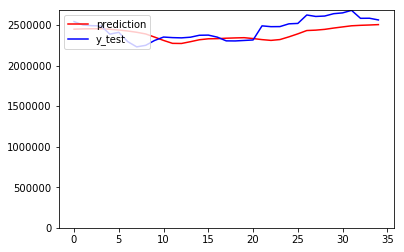

In [149]:
import matplotlib.pyplot as plt2
print stock_name,datetime.datetime.now()
plt2.plot(p*maxclose,color='red', label='prediction')
plt2.plot(y_test*maxclose,color='blue', label='y_test')
plt2.ylim([0,maxclose+100])
plt2.legend(loc='upper left')
plt2.show()

In [150]:
#SAMSUNG

In [151]:
 print "next time"

next time
